# Calculate

Calculate any additional variables that will be compared between WSRA and SWIFT.

In [94]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from IPython import get_ipython

## Setup

Read stored variables from `io.pynb`

In [95]:
def read_stored_variable(variable_name: str):
    """ Read a variable stored by another ipynb instance.

    Read a variable from the current iPython InteractiveShell instance
    using the iPython `store -r`magic command.  The variable is evaluated
    upon return so that the variable is recognized in the development
    environment (e.g., by Pylance in VS code).
    """
    get_ipython().run_line_magic('store', '-r ' + variable_name)
    return eval(variable_name)

In [96]:
%run 'io.ipynb'
atomic_wsra = read_stored_variable('atomic_wsra')
atomic_swifts = read_stored_variable('atomic_swifts')

Stored 'atomic_wsra' (Dataset)
Stored 'atomic_swifts' (dict)
Stored 'atomic_wave_gliders' (dict)
Stored 'atomic_ship' (Dataset)


## SWIFT

In [97]:
def spectral_moment(energy_density, frequency=None, n=0):
    """
    Compute 'nth' spectral moment

    Input:
        - energy, input array of energy densities ([n,1] arr OR [n,m] ndarr)
        - freq, input array of angular_frequencies ([n,1] arr OR [n,m] ndarr)
        - n, moment ([1,] int)

    Output:
        - mn, nth spectral moment ([1,] float)
            * if energy is empty or invalid, mn is assigned a NaN

    Example:

    Compute 4th spectral moment:
        m4 = spectral_moment(energy, freq, n=4)
    """
    if hasattr(energy_density, '__len__') and (not isinstance(energy_density, str)):
        fn = frequency ** n
        mn = np.trapz(energy_density * fn, x=frequency)  # axis=1
    else:
        mn = np.NaN
    return mn

### Energy-weighted mean direction

Compute the energy-weighted mean direction for the SWIFT buoys.  This metric should be more stable than the peak period.

In [98]:
def energy_weighted_mean(
    X: np.ndarray,
    energy_density: np.ndarray,
    frequency: np.ndarray
) -> np.ndarray:
    """ Compute the energy-weighted mean of the input variable X.

    Args:
        X (np.ndarray): frequency-dependent variable of shape (f,n)
        energy_density (np.ndarray): spectral energy density of shape (f,n)
        frequency (np.ndarray): frequency vector of shape (f,n)

    Returns:
        np.ndarray: energy weighted mean of X with shape (n)
    """
    m0 = spectral_moment(energy_density, frequency, n=0)
    weighted_integral = np.trapz(y=energy_density*X, x=frequency)
    return weighted_integral / m0

def direction(a1: np.ndarray, b1: np.ndarray) -> np.ndarray:
    """Compute direction from directional moments a1 and b1.

    Args:
        a1 (np.ndarray): normalized spectral directional moment (+E)
        b1 (np.ndarray): normalized spectral directional moment (+N)

    Returns:
        np.ndarray: direction in meteorological convention
    """
    return (90 - np.rad2deg(np.arctan2(b1, a1))) % 360

In [99]:
for swift_id, swift_ds in atomic_swifts.items():
    energy = swift_ds['energy'].values.T
    energy[np.isnan(energy)] = 0
    frequency = swift_ds['freq'].values
    frequency = np.outer(np.ones(energy.shape[0]), frequency)

    a1_weighted = energy_weighted_mean(swift_ds['a1'].values.T, energy, frequency)
    b1_weighted = energy_weighted_mean(swift_ds['b1'].values.T, energy, frequency)

    swift_ds['mean_direction'] = ('time', direction(a1_weighted, b1_weighted))

Compare to the peak direction

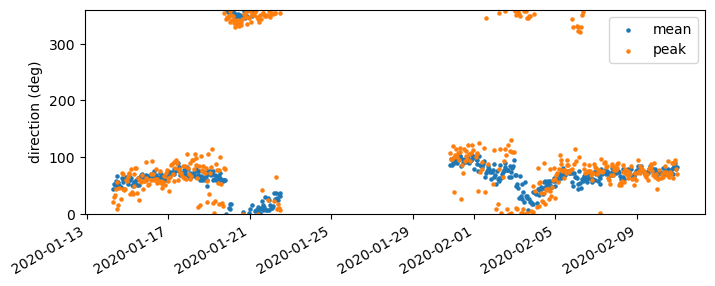

In [100]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.scatter(swift_ds['time'], swift_ds['mean_direction'], label='mean', s=5)
ax.scatter(swift_ds['time'], swift_ds['sea_surface_wave_from_direction_at_variance_spectral_density_maximum'], label='peak', s=5)
ax.set_ylim([0, 360])
ax.set_ylabel('direction (deg)')
ax.legend()
fig.autofmt_xdate()

### Mean square slope

Compute the spectral mean square slope for each SWIFT.

In [101]:
def mean_square_slope(energy_density: np.ndarray, frequency: np.ndarray) -> np.ndarray:
    """Compute spectral mean square slope.

    Args:
        energy_density (np.ndarray): spectral energy density of shape (f,n)
        frequency (np.ndarray): frequency vector of shape (f,n)

    Returns:
        np.ndarray: mean square slope with shape (n,)
    """
    ACC_GRAV = 9.81
    fourth_moment = spectral_moment(energy_density, frequency=frequency, n=4)
    return (2*np.pi)**4 * fourth_moment / (ACC_GRAV**2)

Text(0, 0.5, 'mean square slope (-)')

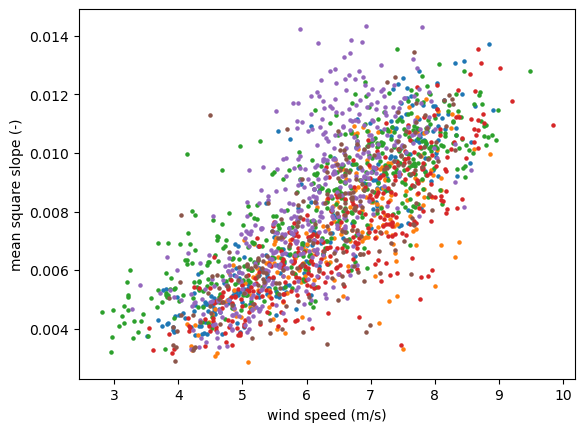

In [102]:
fig, ax = plt.subplots()

for swift_id in atomic_swifts.keys():
    energy = atomic_swifts[swift_id]['energy'].values.T
    energy[np.isnan(energy)] = 0
    frequency = atomic_swifts[swift_id]['freq'].values
    frequency = np.outer(np.ones(energy.shape[0]), frequency)

    mss = mean_square_slope(energy_density=energy, frequency=frequency)
    atomic_swifts[swift_id]['mean_square_slope'] = ('time', mss)

    ax.scatter(atomic_swifts[swift_id]['wind_speed'],
               atomic_swifts[swift_id]['mean_square_slope'],
               s=5)

ax.set_xlabel('wind speed (m/s)')
ax.set_ylabel('mean square slope (-)')

### Day 

Create a `day` variable which represents the date rounded down to the nearest day.  This will be used to isolate ATOMIC missions.

In [103]:
for swift_id in atomic_swifts.keys():
    atomic_swifts[swift_id]['day'] = ('time', atomic_swifts[swift_id].time.dt.floor("D").values)

/opt/homebrew/Caskroom/miniconda/base/envs/PyWSRA/lib/python3.10/site-packages/xarray/core/accessor_dt.py:132: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [104]:
%%capture
%store atomic_swifts

## WSRA

### Timestamp

Create a `timestamp` variable which represents the time in numeric format.  This will be used for plotting and any interpolation.

In [105]:
atomic_wsra['timestamp'] = ('time', pd.to_numeric(atomic_wsra['time'].values))

### Day 

Create a `day` variable which represents the date rounded down to the nearest day.  This will be used to isolate ATOMIC missions.

In [106]:
atomic_wsra['day'] = ('time', atomic_wsra.time.dt.floor("D").values)

### Mask

Create a trajectory mask and overwrite the original data.  Use the limits specified in Pincus et al. (2021).

In [ ]:
atomic_wsra.wsra.create_trajectory_mask(altitude_limits=(500, 4000),
                                        roll_limit=3)
atomic_wsra = atomic_wsra.wsra.mask()

### Colocate

In [76]:
def great_circle_pairwise(
    longitude_a: np.ndarray,
    latitude_a: np.ndarray,
    longitude_b: np.ndarray,
    latitude_b: np.ndarray,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the great circle distance (km) and true fore bearing (deg) between
    pairs of observations in input arrays `longitude_a` and `longitude_b` and
    `latitude_a` and `latitude_b`.

    For two longitude and latitude pairs, the great circle distance is the
    shortest distance between the two points along the Earth's surface. This
    distance is calculated using the Haversine formula. The instances in
    `longitude_a` and `latitude_a` are designated as point `a`; the instances
    in `longitude_b` and `latitude_b` then form point `b`. The true fore
    bearing is the bearing, measured from true north, of `b` as seen from `a`.

    Note:
        When given `latitude_a/b` and `longitude_a/b` of shape (n,), n > 1,
        the great circle distance and fore bearing will be calculated between
        `a` and `b` entries such that the returned arrays will be of shape
        (n,). To compute the great circle distance and bearings between
        adjacent coordinates of single longitude and latitude arrays (i.e.,
        along a trajectory), use `great_circle_pathwise`.

    Args:
        longitude_a (np.array): of shape (n,) in units of decimal degrees
        latitude (np.array): of shape (n,) in units of decimal degrees
        earth_radius (float, optional): earth's radius in units of km. Defaults to 6378.137 km (WGS-84)
        mod_bearing (bool, optional): return bearings modulo 360 deg. Defaults to True.

    Returns:
        Tuple[np.array, np.array]: great circle distances (in km) and true fore
        bearings between adjacent longitude and latitude pairs; shape (n,)

    Example: A trajectory along the Earth's equator.
    ```
    >> #TODO:
    ```
    """
    # Convert decimal degrees to radians
    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # Difference longitude and latitude
    longitude_difference = longitude_b_rad - longitude_a_rad
    latitude_difference = latitude_b_rad - latitude_a_rad

    # Haversine formula
    a_1 = np.sin(latitude_difference / 2) ** 2
    a_2 = np.cos(latitude_a_rad)
    a_3 = np.cos(latitude_b_rad)
    a_4 = np.sin(longitude_difference / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a_1 + a_2 * a_3 * a_4))
    distance_km = earth_radius * c

    # True bearing
    bearing_num = np.cos(latitude_b_rad) * np.sin(-longitude_difference)
    bearing_den_1 = np.cos(latitude_a_rad) * np.sin(latitude_b_rad)
    bearing_den_2 = - np.sin(latitude_a_rad) * np.cos(latitude_b_rad) * np.cos(longitude_difference)
    bearing_deg = -np.degrees(np.arctan2(bearing_num, bearing_den_1 + bearing_den_2))

    if mod_bearing:
        bearing_deg = bearing_deg % 360

    return distance_km, bearing_deg


def colocate_with_path(
    wsra_ds: xr.Dataset,
    path_ds: xr.Dataset,
    path_vars: Tuple,
    wsra_vars: Tuple = ('time', 'latitude', 'longitude'),
    temporal_tolerance: np.timedelta64 = np.timedelta64(30, 'm'),
    spatial_tolerance: float = 1,  # km
) -> Tuple[np.ndarray, np.ndarray]:
    """
    TODO: update!
    Match WSRA observations with gridded data (e.g., a model) using
    linear interpolation in time and bilinear interpolation in space.

    Note:
        `path_vars` and `wsra_vars` are tuples specifying the names of the
        coordinates and fields to interpolate. The names must be ordered as:
        time, latitude, longitude, and field where field is the variable in
        `path_ds` to be in colocated onto the WSRA dataset (and thus is only
        provided only for `path_vars`).

        For instance, if the gridded dataset coordinates are labeled as 'time',
        'lat', and 'lon' and 'wind_speed' is the field to be colocated onto the
        WSRA dataset, `path_vars` should be:
        >>> path_vars = ('time', 'lat', 'lon', 'wind_speed)

        `wsra_vars` defaults to the standard dataset names, though these should
        be provided if the defaults have been modified.

        Out-of-bound points are replaced by NaNs.

    Args:
        wsra_ds (xr.Dataset): WSRA observations
        path_ds (xr.Dataset): gridded data with a field variable to be
            interpolated onto the WSRA observations
        temporal_tolerance (np.timedelta64, optional): max allowable time delta
            between model and grid times. Defaults to np.timedelta64(30, 'm').

    Returns:
        np.ndarray: field variable values interpolated onto the WSRA time and
            spatial coordinates.
    TODO: update!

    """

    wsra_time = wsra_ds[wsra_vars[0]].values
    wsra_latitude = wsra_ds[wsra_vars[1]].values
    wsra_longitude = wsra_ds[wsra_vars[2]].values

    path_time = path_ds[path_vars[0]].values
    path_latitude = path_ds[path_vars[1]].values
    path_longitude = path_ds[path_vars[2]].values

    t_sort_indices = np.searchsorted(path_time, wsra_time)

    t_sort_indices[t_sort_indices >= len(path_time)] = len(path_time)-1

    time_difference = np.abs(wsra_time - path_time[t_sort_indices])

    in_time = time_difference < temporal_tolerance

    distances, bearings = great_circle_pairwise(
        longitude_a=wsra_longitude,
        latitude_a=wsra_latitude,
        longitude_b=path_longitude[t_sort_indices],
        latitude_b=path_latitude[t_sort_indices]
    )

    in_range = distances < spatial_tolerance

    matching_boolean = np.logical_and(in_time, in_range)

    matching_wsra_indices = np.where(matching_boolean)[0]
    matching_path_indices = t_sort_indices[matching_boolean]
    matching_distances = distances[matching_boolean]
    matching_time_differences = time_difference[matching_boolean]

    return matching_wsra_indices, matching_path_indices, matching_distances, matching_time_differences

In [77]:
mission_dates = np.unique(atomic_wsra['day'].dropna(dim='time'))

matches_dict = []
for date in mission_dates:
    wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date, drop=True)

    for swift_id in atomic_swifts.keys():
        match_dict = {}
        swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

        wsra_indices, swift_indices, distance, time_difference \
            = colocate_with_path(
                wsra_ds = wsra_in_mission,
                path_ds = swift_in_mission,
                path_vars = ('time', 'lat', 'lon', ''),
                wsra_vars = ('time', 'latitude', 'longitude'),
                temporal_tolerance = np.timedelta64(60, 'm'),
                spatial_tolerance = 55,  #km
        )
        match_dict['date'] = date
        match_dict['swift_id'] = swift_id
        match_dict['wsra_indices'] = wsra_indices
        match_dict['swift_indices'] = swift_indices
        match_dict['distance'] = distance
        match_dict['time_difference'] = time_difference.astype('timedelta64[s]')
        matches_dict.append(match_dict)

matches_df = (pd.DataFrame(matches_dict)
    .dropna()
    .set_index(['date', 'swift_id'])
)


In [80]:
%%capture
%store atomic_wsra
%store matches_df